# Analiza atrybutów

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [19]:
DIR_DATA = 'data/v3'

In [20]:
artists = pd.read_json(path_or_buf=f'{DIR_DATA}/artists.jsonl', lines=True)
sessions = pd.read_csv(f'{DIR_DATA}/sessions.csv')
tracks = pd.read_json(path_or_buf=f'{DIR_DATA}/tracks.jsonl', lines=True)
users = pd.read_json(path_or_buf=f'{DIR_DATA}/users.jsonl', lines=True)

### Przygotowanie danych do użycia 
- podział sesji według tygodni i utworów
- policzenie danych takich jak liczba odtworzeń, liczba polubień, przyrost odtworzeń, średni czas odtwarzania 

In [21]:
tracks = tracks.rename(columns={'id': 'track_id'})
tracks['release_date'] = pd.to_datetime(tracks['release_date'], errors='coerce')
tracks['release_date'] = tracks['release_date'].dt.year

artists = artists.rename(columns={'id': 'id_artist'})

sessions_df = sessions
sessions_df['timestamp'] = pd.to_datetime(sessions_df['timestamp'])
sessions_df['week'] = sessions_df['timestamp'].dt.strftime('%U')

start_date = pd.to_datetime('2020-12-28')

sessions_df['week'] = (sessions_df['timestamp'] - start_date).dt.days // 7
sessions_df['week'] = sessions_df['week'] + 1

sessions_df = sessions_df[sessions_df.week.isin([1, 158]) == False]

merged_df = pd.merge(tracks[['track_id','duration_ms']], sessions_df, on='track_id', how='inner')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4969300 entries, 0 to 4969299
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   track_id     object        
 1   duration_ms  int64         
 2   session_id   int64         
 3   timestamp    datetime64[ns]
 4   user_id      int64         
 5   event_type   object        
 6   week         int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 303.3+ MB


Liczenie sumy wartości odtworzeń i polubień utworu w danym tygodniu

In [22]:
all_weeks = sorted(sessions_df['week'].unique())
all_tracks = tracks['track_id'].unique()


df1 = pd.DataFrame({'track_id': all_tracks[:]})
df2 = pd.DataFrame({'week': all_weeks[:]})

empty_track_week_df = pd.merge(df1, df2, how='cross')

counts_df = sessions_df.groupby(['week', 'track_id'])['event_type'].value_counts().unstack(fill_value=0)
counts_df = counts_df.rename(columns={'play': 'play_count', 'like': 'like_count', 'skip': 'skip_count'}).reset_index()

tw_counts_df = pd.merge(empty_track_week_df, counts_df, on=['week', 'track_id'], how='left')
tw_counts_df = tw_counts_df.fillna(0)

print(tw_counts_df.tail)
tw_counts_df.info()


<bound method NDFrame.tail of                        track_id  week  like_count  play_count  skip_count
0        0RNxWy0PC3AyH4ThH3aGK6     2         0.0         0.0         0.0
1        0RNxWy0PC3AyH4ThH3aGK6     3         0.0         0.0         0.0
2        0RNxWy0PC3AyH4ThH3aGK6     4         0.0         0.0         0.0
3        0RNxWy0PC3AyH4ThH3aGK6     5         0.0         0.0         0.0
4        0RNxWy0PC3AyH4ThH3aGK6     6         0.0         0.0         0.0
...                         ...   ...         ...         ...         ...
3496267  27Y1N4Q4U3EfDU5Ubw8ws2   153         1.0         1.0         0.0
3496268  27Y1N4Q4U3EfDU5Ubw8ws2   154         0.0         0.0         0.0
3496269  27Y1N4Q4U3EfDU5Ubw8ws2   155         0.0         1.0         1.0
3496270  27Y1N4Q4U3EfDU5Ubw8ws2   156         1.0         1.0         0.0
3496271  27Y1N4Q4U3EfDU5Ubw8ws2   157         1.0         1.0         0.0

[3496272 rows x 5 columns]>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 349

In [23]:
playtime_df = merged_df
playtime_df = playtime_df[playtime_df["event_type"] != "like"].copy()


grouped_df = playtime_df.groupby(['week', 'track_id', 'user_id'])
playtime_df['next_timestamp'] = grouped_df['timestamp'].shift(-1)
playtime_df['next_event_type'] = grouped_df['event_type'].shift(-1)


play_mask = (playtime_df['event_type'] == 'play') & (playtime_df['next_event_type'] == 'skip')
play_duration = (playtime_df['next_timestamp'] - playtime_df['timestamp']).dt.total_seconds() * 1000
track_duration = playtime_df['duration_ms']

playtime_df['playtime_ratio'] = 1
playtime_df.loc[play_mask, 'playtime_ratio'] = play_duration[play_mask] / track_duration[play_mask]


playtime_df = playtime_df.drop(['next_event_type', 'next_timestamp'], axis=1)
playtime_df = playtime_df[playtime_df["event_type"] != "skip"].reset_index()


grouped_playtime = playtime_df[playtime_df['event_type'] == 'play'].groupby(['track_id', 'week'])
mean_playtime = grouped_playtime['playtime_ratio'].mean().reset_index()

mean_playtime.info()
print(mean_playtime[mean_playtime["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160061 entries, 0 to 1160060
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   track_id        1160061 non-null  object 
 1   week            1160061 non-null  int64  
 2   playtime_ratio  1160061 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 26.6+ MB
                      track_id  week  playtime_ratio
327980  27Y1N4Q4U3EfDU5Ubw8ws2     2        1.000000
327981  27Y1N4Q4U3EfDU5Ubw8ws2     3        1.000000
327982  27Y1N4Q4U3EfDU5Ubw8ws2     5        0.882955
327983  27Y1N4Q4U3EfDU5Ubw8ws2     6        1.000000
327984  27Y1N4Q4U3EfDU5Ubw8ws2     8        1.000000
...                        ...   ...             ...
328062  27Y1N4Q4U3EfDU5Ubw8ws2   152        0.989200
328063  27Y1N4Q4U3EfDU5Ubw8ws2   153        1.000000
328064  27Y1N4Q4U3EfDU5Ubw8ws2   155        0.369033
328065  27Y1N4Q4U3EfDU5Ubw8ws2   156        1.000000
328066 

Wyliczanie wartości słuchalnosći w danym tygodniu, oraz jej wartości historycznych w tygodniach poprzednich

In [33]:
all_counts_df = pd.merge(tw_counts_df, mean_playtime, on=['week', 'track_id'], how='left')
all_counts_df = all_counts_df.fillna(0)


all_counts_df['lag_1'] = all_counts_df.groupby('track_id')['play_count'].shift(1)
all_counts_df['lag_2'] = all_counts_df.groupby('track_id')['play_count'].shift(2)
all_counts_df['lag_3'] = all_counts_df.groupby('track_id')['play_count'].shift(3)

 
track_features = ['track_id', 'popularity', 'duration_ms', 'explicit', 'danceability', 
            'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'release_date', 'id_artist']


df_track_artist = pd.merge(tracks[track_features], artists[['id_artist', 'genres' ]], on=['id_artist'], how='left')

full_df = pd.merge(all_counts_df, df_track_artist, on=['track_id'], how='left')
counts_df = full_df

full_df = full_df.fillna(0)


le = LabelEncoder()
mlb = MultiLabelBinarizer()

full_df['id_artist'] = le.fit_transform(full_df['id_artist'])


chunk_size = 1000
chunks = [full_df.iloc[i:i + chunk_size] for i in range(0, len(full_df), chunk_size)]


encoded_chunks = [pd.DataFrame(mlb.fit_transform(chunk['genres']), columns=mlb.classes_, index=chunk.index) for chunk in chunks]
full_df_encoded = pd.concat([full_df.drop('genres', axis=1)] + encoded_chunks, axis=1)


full_df_encoded.info()
full_df_encoded.head()

# unique_genres = full_df['genres'].explode().unique().tolist()
# print(len(unique_genres))
# print(unique_genres)

#print(full_df.tail)
#print(full_df[full_df["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))



## Rozkład popularności w danych

Po analizie wyników możemy zauważyć, że przytłaczająca większość rekordów ma zerową liczbę tygodniowych odtworzeń

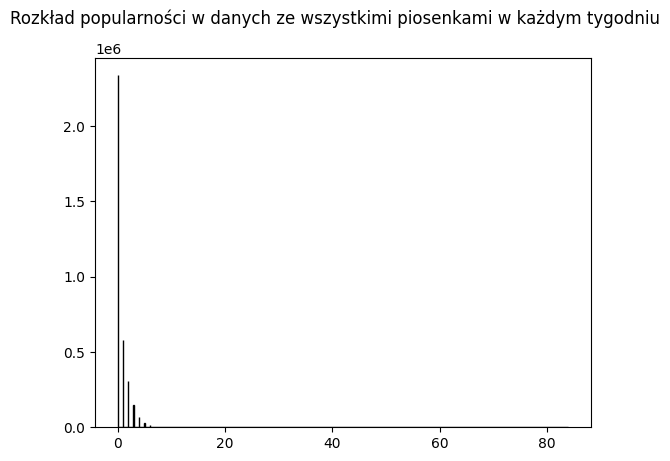

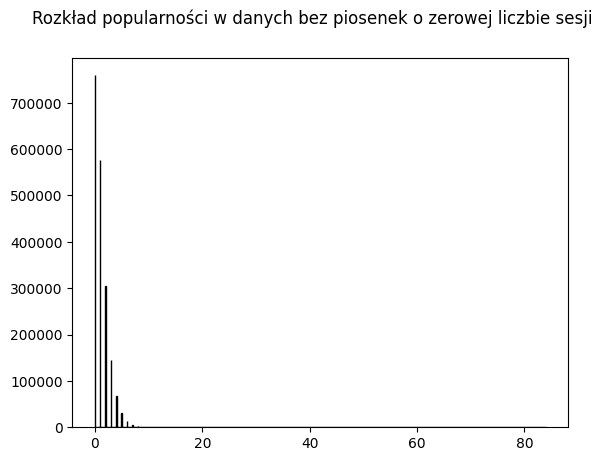

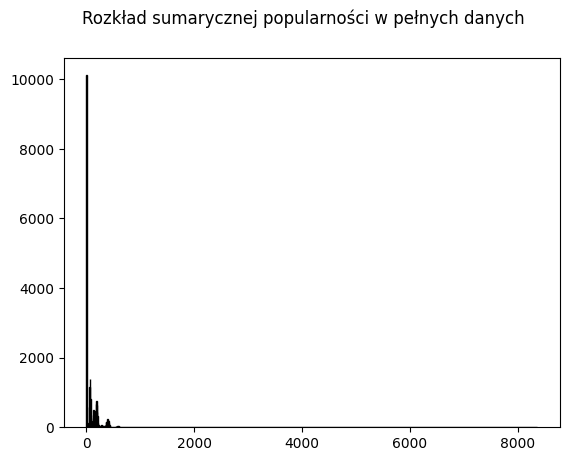

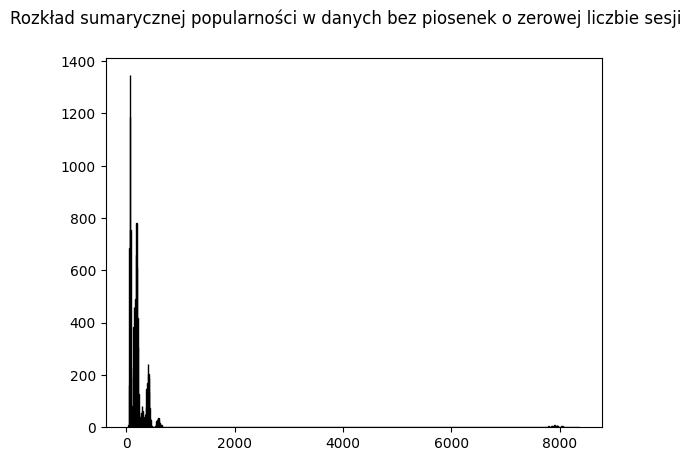

In [25]:
unique_tracks = sessions['track_id'].unique()
df_data2 = full_df[full_df['track_id'].isin(unique_tracks)]

df_data3 = full_df.groupby('track_id')['play_count'].sum().reset_index()
df_data3 = df_data3.merge(full_df.groupby('track_id').first().reset_index().drop(['play_count', 'week', 'lag_1', 'lag_2', 'lag_3'], axis=1), on='track_id', how='inner')
df_data4 = df_data3[df_data3['track_id'].isin(unique_tracks)]

data1 = full_df['play_count']
data2 = df_data2['play_count']
data3 = df_data3['play_count']
data4 = df_data4['play_count']

plt.hist(data1, bins=1000, edgecolor='black')
plt.suptitle('Rozkład popularności w danych ze wszystkimi piosenkami w każdym tygodniu')
plt.show()

plt.hist(data2, bins=1000, edgecolor='black')
plt.suptitle('Rozkład popularności w danych bez piosenek o zerowej liczbie sesji')
plt.show()

plt.hist(data3, bins=1000, edgecolor='black')
plt.suptitle('Rozkład sumarycznej popularności w pełnych danych')
plt.show()

plt.hist(data4, bins=1000, edgecolor='black')
plt.suptitle('Rozkład sumarycznej popularności w danych bez piosenek o zerowej liczbie sesji')
plt.show()

## Pandas ProfileReport - dla całego zbioru danych

In [26]:
# profile = ProfileReport(full_df, title="Pandas Profile Report - Full Data", html={'style':{'full_width':True}})
# Save your output file in html forma
# profile.to_file(output_file= "TS_report.html")

## Macierze korelacji

/tmp/ipykernel_14114/2964204875.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix1 = df1.drop(['track_id', 'week'], axis=1).corr()
/tmp/ipykernel_14114/2964204875.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix2 = df2.drop(['track_id', 'week'], axis=1).corr()
/tmp/ipykernel_14114/2964204875.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix3 = df3.drop(['track_id', 'week'], axis=1).corr()
/tmp/ipykernel_14114/2

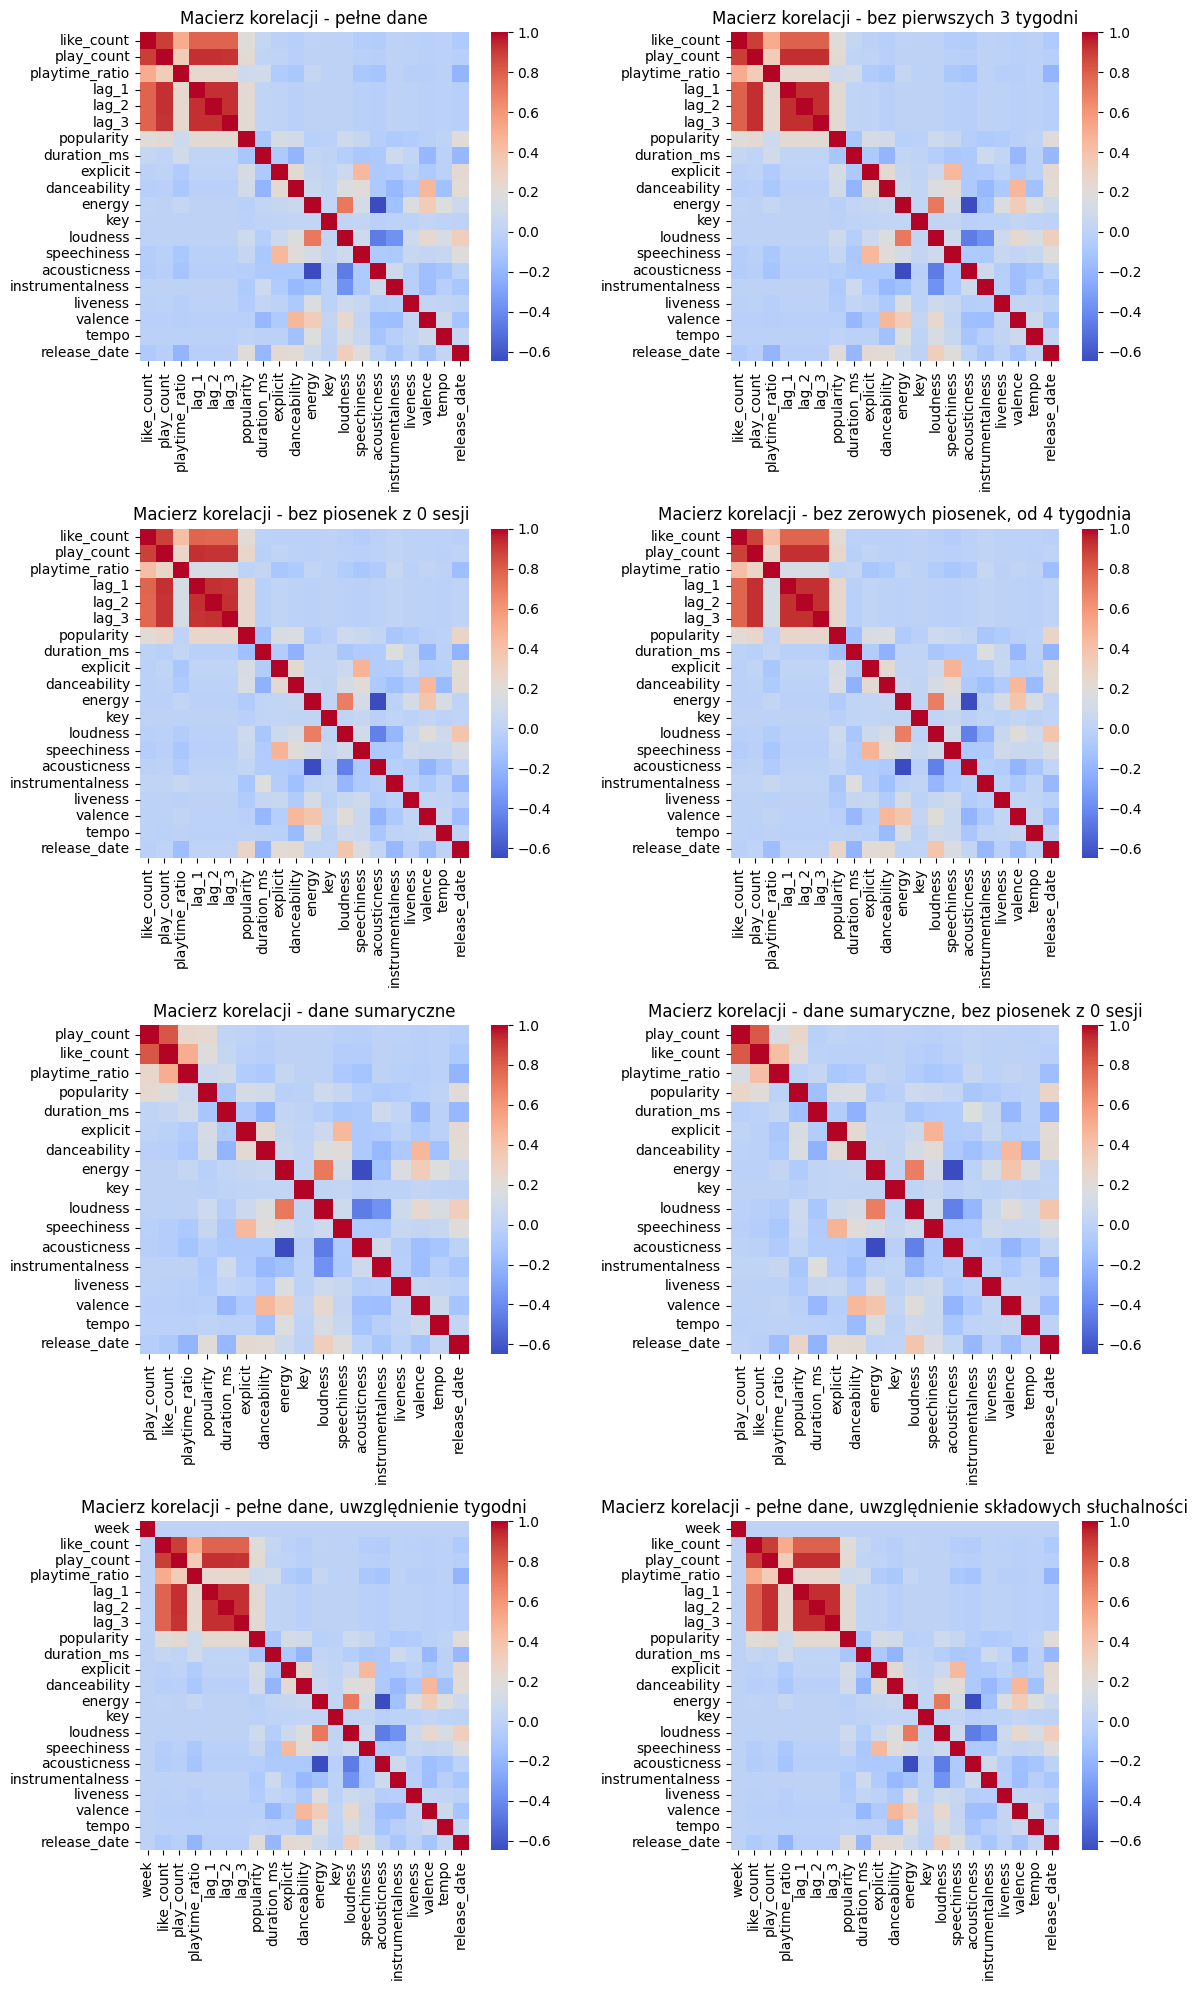

like_count        0.891292
play_count        1.000000
playtime_ratio    0.334455
lag_1             0.926956
lag_2             0.923399
lag_3             0.920365
popularity        0.220147
Name: play_count, dtype: float64
like_count        0.891211
play_count        1.000000
playtime_ratio    0.334557
lag_1             0.930146
lag_2             0.930020
lag_3             0.929965
popularity        0.220146
Name: play_count, dtype: float64
like_count        0.888754
play_count        1.000000
playtime_ratio    0.262038
lag_1             0.923411
lag_2             0.919694
lag_3             0.916531
popularity        0.252961
Name: play_count, dtype: float64
like_count        0.888665
play_count        1.000000
playtime_ratio    0.262102
lag_1             0.926741
lag_2             0.926608
lag_3             0.926553
popularity        0.252951
Name: play_count, dtype: float64
play_count        1.000000
like_count        0.823655
playtime_ratio    0.248150
popularity        0.228231
Name

In [17]:
df1 = full_df                           # pełne dane
df2 = full_df[full_df['week'] > 4]      # bez pierwszych 3 tygodni (tak, żeby lag oznaczał rzeczywistą wartość)
df3 = df_data2                          # tylko dla tracków z sesjami
df4 = df_data2[df_data2['week'] > 4]    # bez pierwszych 3 tygodni (tak, żeby lag oznaczał rzeczywistą wartość), tylko dla tracków z sesjami
df5 = df_data3                          # z sumowaną wartością słuchalności
df6 = df_data4                          # z sumowaną wartością słuchalności, tylko dla tracków z sesjami


fig, axes = plt.subplots(4, 2, figsize=(12, 20))

# macierze korelacji dla różnych danych wejściowych
correlation_matrix1 = df1.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix2 = df2.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix3 = df3.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix4 = df4.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix5 = df5.drop(['track_id'], axis=1).corr()
correlation_matrix6 = df6.drop(['track_id'], axis=1).corr()
correlation_matrix7 = df1.drop(['track_id'], axis=1).corr()
correlation_matrix8 = counts_df.drop(['track_id'], axis=1).corr()

ax = sns.heatmap(correlation_matrix1, cmap='coolwarm', square=True,  ax=axes[0, 0])
axes[0, 0].set_title('Macierz korelacji - pełne dane')

ax = sns.heatmap(correlation_matrix2, cmap='coolwarm', square=True,  ax=axes[0, 1])
axes[0, 1].set_title('Macierz korelacji - bez pierwszych 3 tygodni')

ax = sns.heatmap(correlation_matrix3, cmap='coolwarm', square=True,  ax=axes[1, 0])
axes[1, 0].set_title('Macierz korelacji - bez piosenek z 0 sesji ')

ax = sns.heatmap(correlation_matrix4, cmap='coolwarm', square=True,  ax=axes[1, 1])
axes[1, 1].set_title('Macierz korelacji - bez zerowych piosenek, od 4 tygodnia')

ax = sns.heatmap(correlation_matrix5, cmap='coolwarm', square=True,  ax=axes[2, 0])
axes[2, 0].set_title('Macierz korelacji - dane sumaryczne')

ax = sns.heatmap(correlation_matrix6, cmap='coolwarm', square=True,  ax=axes[2, 1])
axes[2, 1].set_title('Macierz korelacji - dane sumaryczne, bez piosenek z 0 sesji')

ax = sns.heatmap(correlation_matrix7, cmap='coolwarm', square=True,  ax=axes[3, 0])
axes[3, 0].set_title('Macierz korelacji - pełne dane, uwzględnienie tygodni')

ax = sns.heatmap(correlation_matrix8, cmap='coolwarm', square=True,  ax=axes[3, 1])
axes[3, 1].set_title('Macierz korelacji - pełne dane, uwzględnienie składowych słuchalności')

plt.tight_layout()
plt.show()


# Wypis wartości korealcji elementów skorelowanych z słuchalnością co najmniej +/- 5%
print(correlation_matrix1[abs(correlation_matrix1['play_count']) > 0.05]['play_count']) 
print(correlation_matrix2[abs(correlation_matrix2['play_count']) > 0.05]['play_count']) 
print(correlation_matrix3[abs(correlation_matrix3['play_count']) > 0.05]['play_count']) 
print(correlation_matrix4[abs(correlation_matrix4['play_count']) > 0.05]['play_count'])
print(correlation_matrix5[abs(correlation_matrix5['play_count']) > 0.05]['play_count']) 
print(correlation_matrix6[abs(correlation_matrix6['play_count']) > 0.05]['play_count']) 
print(correlation_matrix7[abs(correlation_matrix7['play_count']) > 0.05]['play_count']) 
print(correlation_matrix8[abs(correlation_matrix8['play_count']) > 0.05]['play_count']) 

## Prosty model regresji dla przewidywania słuchalności każdego z utworów

In [73]:
# Jeden model dla wszystkich piosenek

features = ['lag_1', 'lag_2', 'lag_3']
target = ['listenability']
dataset = full_df

train_x = df4[df4['week'] <= 42][features]
train_y = df4[df4['week'] <= 42][target]
test_x = dataset[dataset['week'] > 42][features]
test_y = dataset[dataset['week'] > 42][['track_id', 'listenability']]


model = LinearRegression()
model.fit(train_x, train_y)

# Make predictions on the test set
test_y['predicted'] = model.predict(test_x)

# Calculate the Mean Squared Error on the test set
mse_test = mean_squared_error(test_y['listenability'], test_y['predicted'])
print(f"Mean Squared Error on Test Set: {mse_test}")

# Lista top20 utworów w tygodniu 44
test_y_44 = test_y.iloc[10::10]

top_20_real = test_y_44.nlargest(20, 'listenability')
top_20_preddicted = test_y_44.nlargest(20, 'predicted')
print(top_20_real)
print(top_20_preddicted)


Mean Squared Error on Test Set: 2.053954929334688
                      track_id  listenability  predicted
495557  4C6BlqqMwjFzOXzqpTeoWR      68.811719  51.258025
452819  0pqnGHJpmpxLKifKRmU6WP      66.131027  48.916519
466895  3ee8Jmje8o58CHK66QrVC2      64.104012  54.980636
494333  3YJJjQPAbDT7mGpX3WtQ9A      63.463288  56.573759
60527   0ofHAoxe9vBkTCp2UQIavz      62.054550  57.574489
506216  31qCy5ZaophVA81wtlwLc4      61.603871  60.859068
494843  5vGLcdRuSbUhD8ScwsGSdA      60.575517  47.813752
467048  2ZRo7axmMPeSVUvDbGkJah      60.236351  53.426711
495098  0E4Y1XIbs8GrAT1YqVy6dq      59.732466  56.088662
481685  2XU0oxnq2qxCpomAAuJY8K      59.617916  56.527723
438080  55Am8neGJkdj2ADaM3aw5H      59.394068  58.471402
481889  6Hj9jySrnFppAI0sEMCZpJ      59.305877  52.657497
494027  5QO79kh1waicV47BqGRL3g      58.515260  56.053994
505910  2TksvaRivgAEj780DgRB73      58.428503  48.067323
494384  35mvY5S1H3J2QZyna3TFe0      58.326035  55.599596
495149  1VLtjHwRWOVJiE5Py7JxoQ      58